## Import Library

In [1]:
pip show pyspark

Name: pyspark
Version: 3.4.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show spark-nlp

Name: spark-nlp
Version: 6.2.2
Summary: John Snow Labs Spark NLP is a natural language processing library built on top of Apache Spark ML. It provides simple, performant & accurate NLP annotations for machine learning pipelines, that scale easily in a distributed environment.
Home-page: https://github.com/JohnSnowLabs/spark-nlp
Author: John Snow Labs
Author-email: 
License: 
Location: c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_461"
os.environ["HADOOP_HOME"] = "C:/hadoop"

import sparknlp
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("SparkNLP")
         .config("spark.driver.memory", "8G")
         .config("spark.kryoserializer.buffer.max", "2000M")
         .config("spark.hadoop.native.io.enabled", "false")
         .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:6.2.2")
         .getOrCreate())
spark = sparknlp.start()
print("Spark NLP:", sparknlp.version())


Spark NLP: 6.2.2


In [4]:
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, SentenceDetector, Normalizer
import pandas as pd

df_yt = spark.read.csv(
    "scraped/.ipynb_checkpoints/youtube_comments_full.csv",
    header=True,
    inferSchema=True
)
df_yt

DataFrame[user: string, timestamp_raw: string, timestamp_date: string, comment: string, like_count: string, reply_count: string, reply_text: string]

In [5]:
df_yt.printSchema()

root
 |-- user: string (nullable = true)
 |-- timestamp_raw: string (nullable = true)
 |-- timestamp_date: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- like_count: string (nullable = true)
 |-- reply_count: string (nullable = true)
 |-- reply_text: string (nullable = true)



In [6]:
df_yt.show(10, truncate=False)

+----+--------------------------+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------+-----------------------------------------------------------+------------------------------------------------------------------------------------------------+
|user|timestamp_raw             |timestamp_date            |commen

In [7]:
df_yt_text = df_yt.select("comment")
df_yt_text.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment                                                                                                                                                                                                                                                                                                                                    

In [8]:
df_text = df_yt.selectExpr("comment as text")
df_text.show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                          |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|I know this game is getting a ton of hate but you guys have to understand that this is Ubisoft's last chance to stay in business so it's extra important that we all band together as a group and don't buy it|
|“Life is too short to play a game that is just ‘ok I guess’”.  Amen brother, the older I get, the more I relate to this                                            

In [9]:
jumlah_data = df_text.count()
print(jumlah_data)

1309


In [10]:
from pyspark.sql.functions import col

df_text.filter(col("comment").isNull()).count()


72

In [11]:
df_text_clean = df_text.dropna(subset=["text"])

print("Jumlah data setelah drop null:", df_text_clean.count())


Jumlah data setelah drop null: 1237


In [12]:
df_text_clean.filter(df_text_clean.text.isNull()).count()


0

In [13]:
from pyspark.sql.functions import lower, regexp_replace, trim

df_clean = df_text_clean.withColumn(
    "clean_text",
    trim(
        lower(
            regexp_replace("text", "[^a-zA-Z\\s]", "")
        )
    )
)

df_clean.select("text", "clean_text").show(10, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="clean_text",
    outputCol="tokens"
)

df_token = tokenizer.transform(df_clean)

df_token.select("clean_text", "tokens").show(10, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens"
)

df_filtered = remover.transform(df_token)

df_filtered.select("tokens", "filtered_tokens").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                |filtered_tokens                                                                                                                               |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
from pyspark.sql.functions import size

df_filtered.withColumn(
    "token_count",
    size("filtered_tokens")
).select("token_count").show(5)


+-----------+
|token_count|
+-----------+
|         19|
|         12|
|          7|
|         11|
|          5|
+-----------+
only showing top 5 rows



In [17]:
from pyspark.sql.functions import size

df_token_count = df_filtered.withColumn(
    "token_count",
    size("filtered_tokens")
)

df_token_count.select("token_count").show(5)


+-----------+
|token_count|
+-----------+
|         19|
|         12|
|          7|
|         11|
|          5|
+-----------+
only showing top 5 rows



In [18]:
token_count_pd = df_token_count.select("token_count") \
    .sample(fraction=0.1, seed=42) \
    .toPandas()


In [19]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


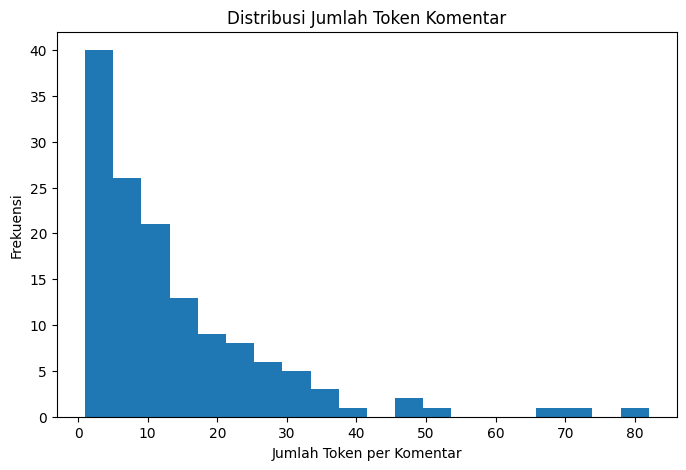

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(token_count_pd["token_count"], bins=20)
plt.xlabel("Jumlah Token per Komentar")
plt.ylabel("Frekuensi")
plt.title("Distribusi Jumlah Token Komentar")
plt.show()


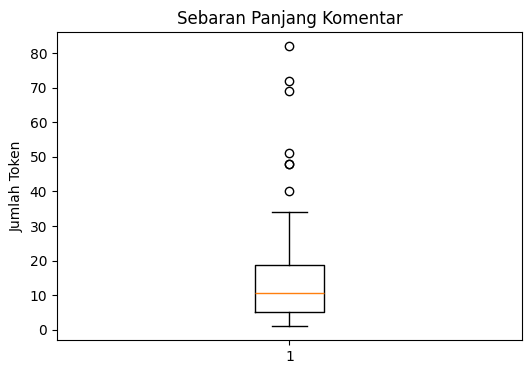

In [21]:
plt.figure(figsize=(6,4))
plt.boxplot(token_count_pd["token_count"])
plt.ylabel("Jumlah Token")
plt.title("Sebaran Panjang Komentar")
plt.show()


In [22]:
from pyspark.sql.functions import explode

df_words = df_filtered.select(
    explode("filtered_tokens").alias("word")
)

df_words.show(10)


+----------+
|      word|
+----------+
|      know|
|      game|
|   getting|
|       ton|
|      hate|
|      guys|
|understand|
|  ubisofts|
|      last|
|    chance|
+----------+
only showing top 10 rows



In [23]:
df_word_count = df_words.groupBy("word").count() \
    .orderBy("count", ascending=False)

df_word_count.show(20, truncate=False)


+---------+-----+
|word     |count|
+---------+-----+
|game     |608  |
|         |533  |
|like     |233  |
|games    |194  |
|ac       |194  |
|creed    |144  |
|play     |144  |
|im       |142  |
|ubisoft  |135  |
|dont     |131  |
|assassins|121  |
|ghost    |111  |
|buy      |111  |
|good     |104  |
|one      |99   |
|tsushima |98   |
|really   |95   |
|valhalla |86   |
|get      |86   |
|story    |82   |
+---------+-----+
only showing top 20 rows



In [24]:
top_words_pd = df_word_count.limit(20).toPandas()
top_words_pd


,word,count
0,game,608
1,,533
2,like,233
3,games,194
4,ac,194
5,creed,144
6,play,144
7,im,142
8,ubisoft,135
9,dont,131


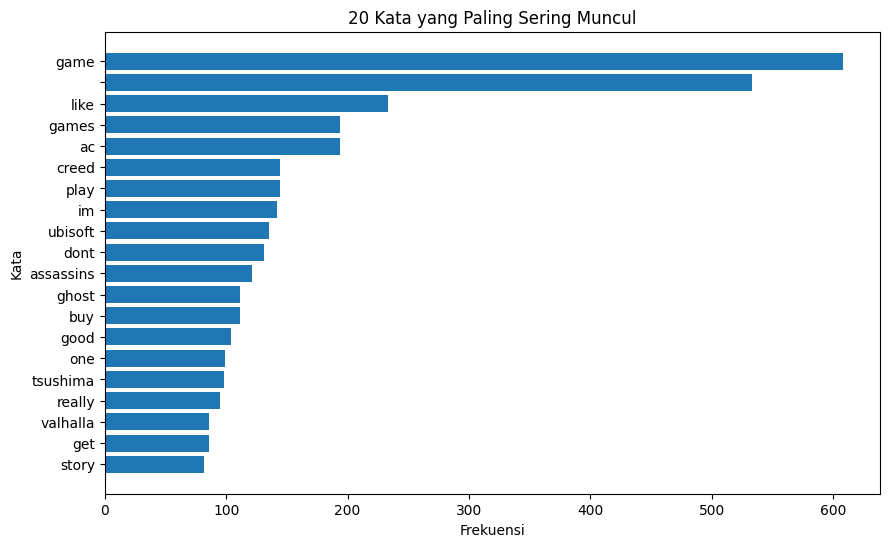

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(
    top_words_pd["word"],
    top_words_pd["count"]
)
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.title("20 Kata yang Paling Sering Muncul")
plt.gca().invert_yaxis()
plt.show()


In [26]:
custom_stopwords = ["video", "channel", "youtube"]

df_words_filtered = df_words.filter(
    ~df_words.word.isin(custom_stopwords)
)

df_words_filtered.groupBy("word").count() \
    .orderBy("count", ascending=False) \
    .show(200)


+----------+-----+
|      word|count|
+----------+-----+
|      game|  608|
|          |  533|
|      like|  233|
|     games|  194|
|        ac|  194|
|     creed|  144|
|      play|  144|
|        im|  142|
|   ubisoft|  135|
|      dont|  131|
| assassins|  121|
|       buy|  111|
|     ghost|  111|
|      good|  104|
|       one|   99|
|  tsushima|   98|
|    really|   95|
|  valhalla|   86|
|       get|   86|
|     story|   82|
|   playing|   77|
|    people|   72|
|     think|   72|
|    better|   70|
|      time|   68|
|      even|   64|
|      love|   62|
|   shadows|   62|
|       got|   59|
|    played|   58|
|     black|   58|
|     great|   56|
|   odyssey|   56|
|       way|   55|
|     looks|   55|
|      hate|   54|
|     hours|   54|
|      much|   54|
|      cant|   53|
|     still|   52|
|      make|   52|
|       fun|   51|
|       ive|   51|
|      want|   50|
|    review|   50|
|      know|   47|
|     never|   45|
|     first|   45|
|     since|   45|
|    yasuke|

In [27]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(
    inputCol="filtered_tokens",
    outputCol="raw_features",
    numFeatures=5000
)

df_tf = hashingTF.transform(df_filtered)

df_tf.select("filtered_tokens", "raw_features").show(3, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                               |raw_features                                                                                                                                                                   |
+----------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[know, game, getting, ton, hate, guy

In [28]:
from pyspark.ml.feature import IDF

idf = IDF(
    inputCol="raw_features",
    outputCol="features"
)

idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

df_tfidf.select("features").show(3, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------

In [29]:
df_tfidf.printSchema()

root
 |-- text: string (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [30]:
from pyspark.sql.functions import expr

df_filtered_clean = df_filtered.withColumn(
    "filtered_tokens",
    expr("filter(filtered_tokens, x -> x != '')")
)


In [31]:
from pyspark.sql.functions import length

df_clean_nonempty = df_clean.filter(
    length("clean_text") > 0
)

print("Jumlah data setelah filter teks kosong:", df_clean_nonempty.count())


Jumlah data setelah filter teks kosong: 1167


In [32]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="clean_text",
    outputCol="tokens"
)

df_token = tokenizer.transform(df_clean_nonempty)


In [33]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens"
)

df_filtered = remover.transform(df_token)


In [34]:
from pyspark.sql.functions import size

df_filtered.select(
    size("filtered_tokens").alias("token_count")
).show(5)


+-----------+
|token_count|
+-----------+
|         19|
|         12|
|          7|
|         11|
|          5|
+-----------+
only showing top 5 rows



In [35]:
from pyspark.sql.functions import explode

df_words = df_filtered.select(
    explode("filtered_tokens").alias("word")
)

df_words.groupBy("word").count() \
    .orderBy("count", ascending=False) \
    .show(200, truncate=False)


+----------+-----+
|word      |count|
+----------+-----+
|game      |608  |
|          |463  |
|like      |233  |
|games     |194  |
|ac        |194  |
|creed     |144  |
|play      |144  |
|im        |142  |
|ubisoft   |135  |
|dont      |131  |
|assassins |121  |
|buy       |111  |
|ghost     |111  |
|good      |104  |
|one       |99   |
|tsushima  |98   |
|really    |95   |
|valhalla  |86   |
|get       |86   |
|story     |82   |
|playing   |77   |
|people    |72   |
|think     |72   |
|better    |70   |
|time      |68   |
|even      |64   |
|love      |62   |
|shadows   |62   |
|got       |59   |
|played    |58   |
|black     |58   |
|great     |56   |
|odyssey   |56   |
|way       |55   |
|looks     |55   |
|hate      |54   |
|hours     |54   |
|much      |54   |
|cant      |53   |
|still     |52   |
|make      |52   |
|fun       |51   |
|ive       |51   |
|want      |50   |
|review    |50   |
|know      |47   |
|never     |45   |
|first     |45   |
|since     |45   |
|yasuke    |

In [36]:
from pyspark.sql.functions import explode, col

df_words = df_filtered.select(
    explode("filtered_tokens").alias("word")
)

df_words_clean = df_words.filter(
    col("word") != ""
)


In [37]:
df_word_count = df_words_clean.groupBy("word").count() \
    .orderBy("count", ascending=False)

df_word_count.show(20, truncate=False)


+---------+-----+
|word     |count|
+---------+-----+
|game     |608  |
|like     |233  |
|games    |194  |
|ac       |194  |
|creed    |144  |
|play     |144  |
|im       |142  |
|ubisoft  |135  |
|dont     |131  |
|assassins|121  |
|ghost    |111  |
|buy      |111  |
|good     |104  |
|one      |99   |
|tsushima |98   |
|really   |95   |
|valhalla |86   |
|get      |86   |
|story    |82   |
|playing  |77   |
+---------+-----+
only showing top 20 rows



In [38]:
df_word_count.filter(col("word") == "").count()

0

In [39]:
positive_seed = ["good", "great", "love", "amazing", "awesome"]
negative_seed = ["bad", "hate", "boring", "sucks", "shit"]


In [40]:
from pyspark.sql.functions import array_intersect, size, array, lit

positive_seed_arr = array(*[lit(x) for x in positive_seed])
negative_seed_arr = array(*[lit(x) for x in negative_seed])

df_context = df_filtered.withColumn(
    "has_positive",
    size(array_intersect("filtered_tokens", positive_seed_arr)) > 0
).withColumn(
    "has_negative",
    size(array_intersect("filtered_tokens", negative_seed_arr)) > 0
)

df_context.select("filtered_tokens", "has_positive", "has_negative").show(5, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------+------------+------------+
|filtered_tokens                                                                                                                               |has_positive|has_negative|
+----------------------------------------------------------------------------------------------------------------------------------------------+------------+------------+
|[know, game, getting, ton, hate, guys, understand, ubisofts, last, chance, stay, business, extra, important, band, together, group, dont, buy]|false       |true        |
|[life, short, play, game, ok, guess, , amen, brother, older, get, relate]                                                                     |false       |false       |
|[gameranx, doesnt, trashtalk, games, hear, fine, paper]                                                                                       |f

In [41]:
total_docs = df_context.count()
positive_docs = df_context.filter("has_positive = true").count()
negative_docs = df_context.filter("has_negative = true").count()

print("Total docs    :", total_docs)
print("Positive docs :", positive_docs)
print("Negative docs :", negative_docs)



Total docs    : 1167
Positive docs : 203
Negative docs : 132


In [42]:
from pyspark.sql.functions import explode

df_words = df_context.select(
    explode("filtered_tokens").alias("word"),
    "has_positive",
    "has_negative"
)


In [43]:
from pyspark.sql.functions import sum as spark_sum

word_stats = df_words.groupBy("word").agg(
    spark_sum(df_words.has_positive.cast("int")).alias("pos_count"),
    spark_sum(df_words.has_negative.cast("int")).alias("neg_count"),
    spark_sum((df_words.has_positive | df_words.has_negative).cast("int")).alias("context_count")
)

word_stats.show(10)


+----------+---------+---------+-------------+
|      word|pos_count|neg_count|context_count|
+----------+---------+---------+-------------+
|     still|       17|        6|           21|
| connected|        3|        0|            3|
|      hope|        2|        0|            2|
|    online|        3|        1|            3|
|     himor|        0|        1|            1|
|    spared|        0|        1|            1|
|       art|        2|        0|            2|
|  priority|        1|        0|            1|
|creativity|        0|        0|            0|
|     trail|        0|        0|            0|
+----------+---------+---------+-------------+
only showing top 10 rows



In [44]:
from pyspark.sql.functions import log, col, lit

word_pmi = word_stats.withColumn(
    "pmi_positive",
    log(
        (col("pos_count") / lit(total_docs)) /
        ((col("context_count") / lit(total_docs)) * (lit(positive_docs) / lit(total_docs)))
    )
).withColumn(
    "pmi_negative",
    log(
        (col("neg_count") / lit(total_docs)) /
        ((col("context_count") / lit(total_docs)) * (lit(negative_docs) / lit(total_docs)))
    )
)

# Tangani NaN/inf akibat pembagian nol
word_pmi = word_pmi.fillna(0)


In [45]:
word_sentiment = word_pmi.withColumn(
    "sentiment_score",
    col("pmi_positive") - col("pmi_negative")
)


In [46]:
word_sentiment.orderBy(col("sentiment_score").desc()).show(20, truncate=False)


+--------+---------+---------+-------------+------------------+--------------------+------------------+
|word    |pos_count|neg_count|context_count|pmi_positive      |pmi_negative        |sentiment_score   |
+--------+---------+---------+-------------+------------------+--------------------+------------------+
|u       |13       |1        |14           |1.6748776810910468|-0.4596676199150734 |2.13454530100612  |
|amazing |22       |2        |22           |1.7489856532447687|-0.21850556309818536|1.967491216342954 |
|vibes   |1        |0        |1            |1.7489856532447687|0.0                 |1.7489856532447687|
|assasins|2        |0        |2            |1.7489856532447687|0.0                 |1.7489856532447687|
|jumping |1        |0        |1            |1.7489856532447687|0.0                 |1.7489856532447687|
|hope    |2        |0        |2            |1.7489856532447687|0.0                 |1.7489856532447687|
|used    |4        |0        |4            |1.7489856532447687|0

In [47]:
from pyspark.sql.functions import col

word_sentiment_filtered = word_sentiment.filter(
    col("context_count") >= 10
)

word_sentiment_filtered.orderBy(
    col("sentiment_score").desc()
).show(20, truncate=False)


+---------+---------+---------+-------------+------------------+--------------------+------------------+
|word     |pos_count|neg_count|context_count|pmi_positive      |pmi_negative        |sentiment_score   |
+---------+---------+---------+-------------+------------------+--------------------+------------------+
|u        |13       |1        |14           |1.6748776810910468|-0.4596676199150734 |2.13454530100612  |
|amazing  |22       |2        |22           |1.7489856532447687|-0.21850556309818536|1.967491216342954 |
|good     |104      |18       |104          |1.7489856532447687|0.42537056845497717 |1.3236150847897916|
|great    |56       |10       |56           |1.7489856532447687|0.45662311195908156 |1.2923625412856872|
|see      |15       |3        |16           |1.6844471321071977|0.5054132761285136  |1.179033855978684 |
|love     |62       |13       |62           |1.7489856532447687|0.6172046821166304  |1.1317809711281384|
|awesome  |22       |5        |22           |1.74898565

In [48]:
common_words = ["u", "im", "dont", "ive", "ill", "thats"]

word_sentiment_filtered = word_sentiment_filtered.filter(
    ~col("word").isin(common_words)
)

In [49]:
from pyspark.sql.functions import col

viz_df = word_sentiment_filtered.select(
    "word", "sentiment_score"
).orderBy(col("sentiment_score").desc())


In [50]:
top_pos = viz_df.limit(10).toPandas()
top_neg = viz_df.orderBy(col("sentiment_score").asc()).limit(10).toPandas()


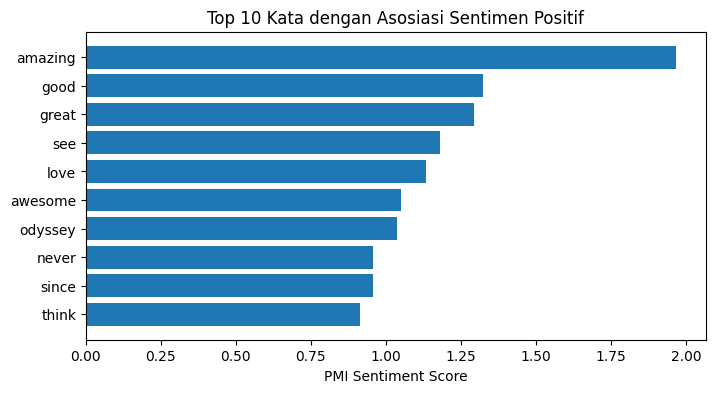

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.barh(top_pos["word"], top_pos["sentiment_score"])
plt.xlabel("PMI Sentiment Score")
plt.title("Top 10 Kata dengan Asosiasi Sentimen Positif")
plt.gca().invert_yaxis()
plt.show()


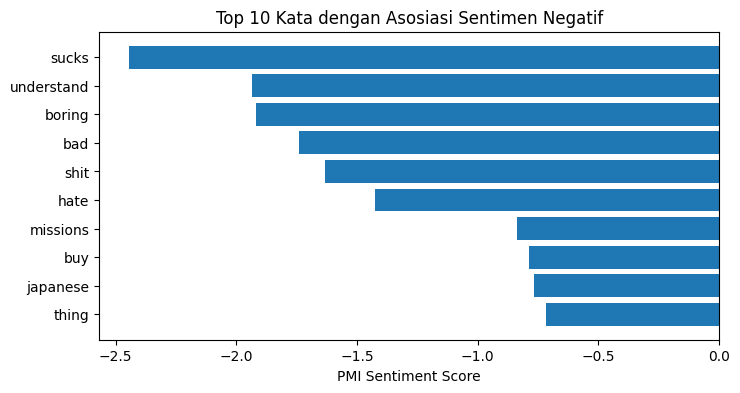

In [52]:
plt.figure(figsize=(8,4))
plt.barh(top_neg["word"], top_neg["sentiment_score"])
plt.xlabel("PMI Sentiment Score")
plt.title("Top 10 Kata dengan Asosiasi Sentimen Negatif")
plt.gca().invert_yaxis()
plt.show()
